In [9]:
import os
import torch
import pickle
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, losses, SentencesDataset, InputExample, models
from transformers import AutoTokenizer, AutoModel
import os
import pickle
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from transformers import AutoTokenizer, AutoModel
import h3
from tqdm import tqdm
import folium
from folium import features

In [10]:
num_gpus = torch.cuda.device_count()

In [11]:
input_pickle_path = 'DataSet_triplet/PUNJAB_05_without_city.pkl'

with open(input_pickle_path, 'rb') as f:
    data = pickle.load(f)

triplets = data.get('triplets', [])
addresses = data.get('addresses', [])
lat_lngs = data.get('lat_lngs', [])

print(f"Length of triplets: {len(triplets)}, {triplets[-1]}")
print(f"Length of addresses: {len(addresses)}, {addresses[-1]}")
print(f"Length of lat_lngs: {len(lat_lngs)}, {lat_lngs[-1]}")

Length of triplets: 3217904, (1114168, 1114167, 1114099, 3)
Length of addresses: 1114180, wardno 1 vpo sarhala ranuan
Length of lat_lngs: 1114180, [31.2044125, 75.8583784]


In [12]:
def get_embedding(model, text):
    inputs = tokenizer(text, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

def get_embeddings(model, texts):
    embeddings = [get_embedding(model, text) for text in tqdm(texts, desc="Computing embeddings")]
    return np.vstack(embeddings)

def plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=5, resolution=10, output_path='tsne_grid_plot.png' , random_n=0, perplexity=10):

    h3_indices = [h3.geo_to_h3(lat, lng, resolution) for lat, lng in lat_lngs]

    if grid_ids is None:
        if random_n == 1:
            unique_grids = list(set(h3_indices))  
            selected_grids = np.random.choice(unique_grids, num_grids, replace=False)
        else:
            unique_grids = list(set(h3_indices))
            selected_grids = unique_grids[:num_grids]
    else:
        selected_grids = grid_ids
    
    selected_addresses = [addresses[i] for i in range(len(addresses)) if h3_indices[i] in selected_grids]
    selected_h3_indices = [h3_indices[i] for i in range(len(h3_indices)) if h3_indices[i] in selected_grids]
    
    embeddings = get_embeddings(model, selected_addresses)
    
    tsne = TSNE(n_components=2, random_state=42,perplexity=perplexity)
    tsne_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=selected_h3_indices, palette="tab10")
    plt.title('t-SNE Plot of Address Embeddings in Specified Grids')
    plt.legend(title='Grid ID')
    plt.savefig(output_path)
    plt.show()
    return selected_grids

def plot_h3_grids(lat_lngs, selected_grids, resolution=10, output_path='h3_grid_plot.png'):
    plt.figure(figsize=(12, 8))
    for grid in selected_grids:
        boundary = h3.h3_to_geo_boundary(grid)
        boundary = list(boundary) + [boundary[0]]  
        boundary = np.array(boundary)
        plt.plot(boundary[:, 1], boundary[:, 0], 'k-')  
        plt.fill(boundary[:, 1], boundary[:, 0], alpha=0.4)

    plt.title('H3 Grid Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(output_path)
    plt.show()

def plot_h3_grids_folium(lat_lngs, selected_grids, resolution=10, output_path='h3_grid_map.html'):

    center_lat = np.mean([lat for lat, lng in lat_lngs])
    center_lng = np.mean([lng for lat, lng in lat_lngs])
    map_folium = folium.Map(location=[center_lat, center_lng], zoom_start=12)

    for grid in selected_grids:
        boundary = h3.h3_to_geo_boundary(grid)
        boundary = [(lat, lng) for lat, lng in boundary]  
        boundary.append(boundary[0])  
        
        folium.Polygon(locations=boundary, color='blue', fill=True, fill_opacity=0.4).add_to(map_folium)

    map_folium.save(output_path)

    return map_folium

In [13]:
def plot_h3_grids(lat_lngs, selected_grids, resolution=10, output_path='h3_grid_plot.png'):
    plt.figure(figsize=(12, 8))
    for grid in selected_grids:
        boundary = h3.h3_to_geo_boundary(grid)
        boundary = list(boundary) + [boundary[0]]  
        boundary = np.array(boundary)
        plt.plot(boundary[:, 1], boundary[:, 0], 'k-', linewidth=3)  
        plt.fill(boundary[:, 1], boundary[:, 0], alpha=1)

In [14]:
def load_finetuned_model(checkpoint_path):
    device = torch.device('cuda' if num_gpus > 0 else 'cpu')
    model = AutoModel.from_pretrained(checkpoint_path)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    model = model.to(device)
    return model , tokenizer , device

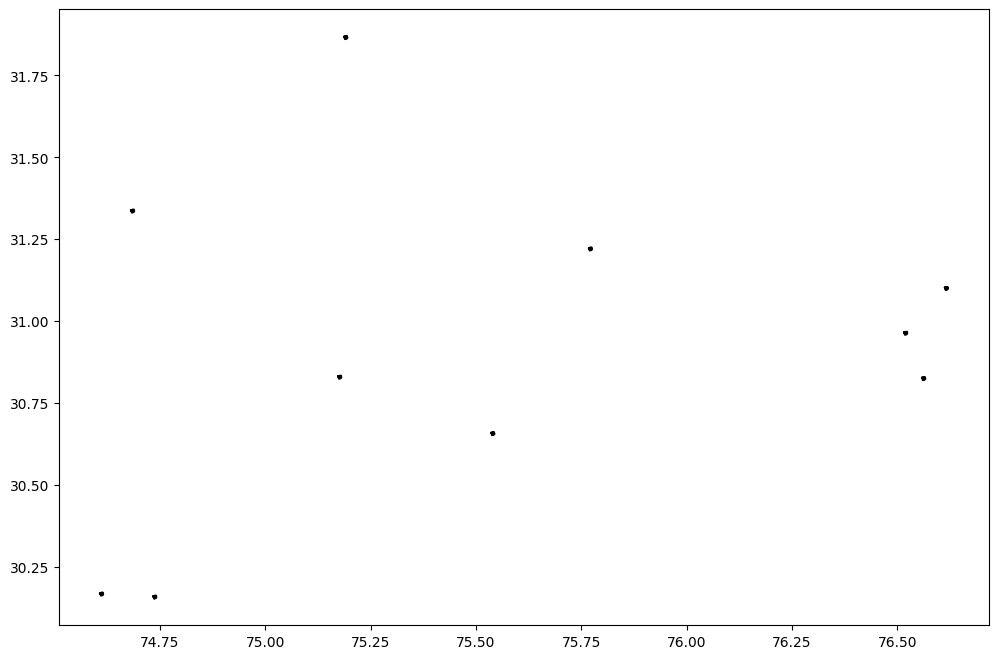

In [12]:
plot_h3_grids(lat_lngs, selected_grids, resolution=10, output_path='h3_grid_plot.png')


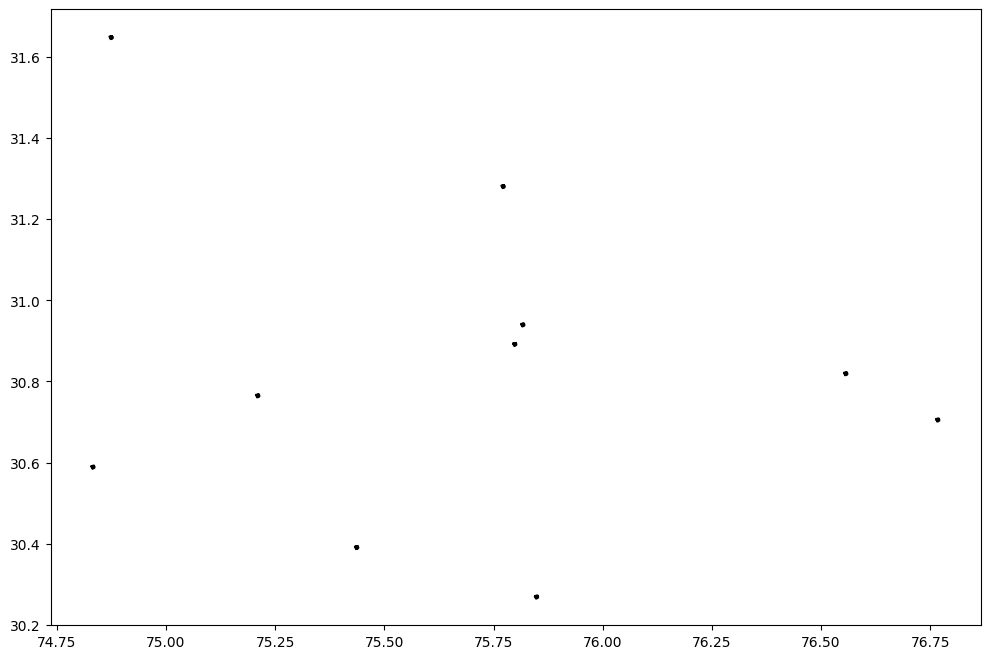

In [11]:
plot_h3_grids(lat_lngs, selected_grids, resolution=10, output_path='h3_grid_plot.png')

## Roberta- Triplet fine-tuned (15 epochs)
-- Dataset with addresses having more than 10 deliveries for now!!

-- Unique Addresses : 0.28 Million 


In [29]:
### roberta_punjab_base_1

Some weights of RobertaModel were not initialized from the model checkpoint at /home/uddeshya.singh/DataSet_triplet/Roberta_classification_r and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:02<00:00, 205.31it/s]


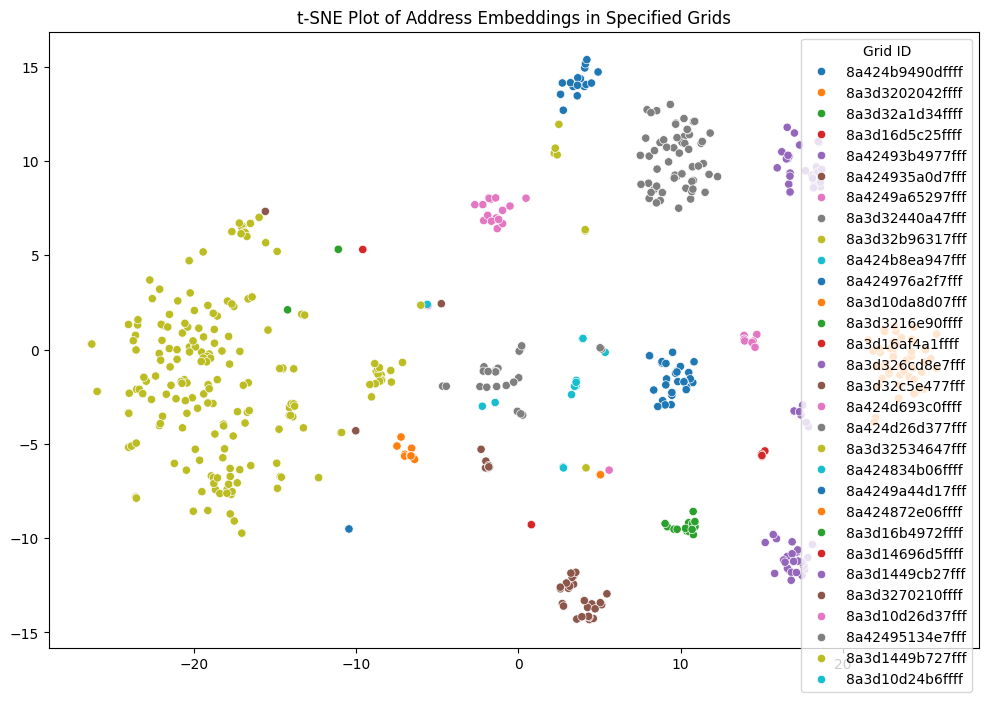

In [30]:
checkpoint_path = '/home/uddeshya.singh/DataSet_triplet/Roberta_classification_r'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=30, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 ,perplexity = 50)

Computing embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:02<00:00, 200.25it/s]


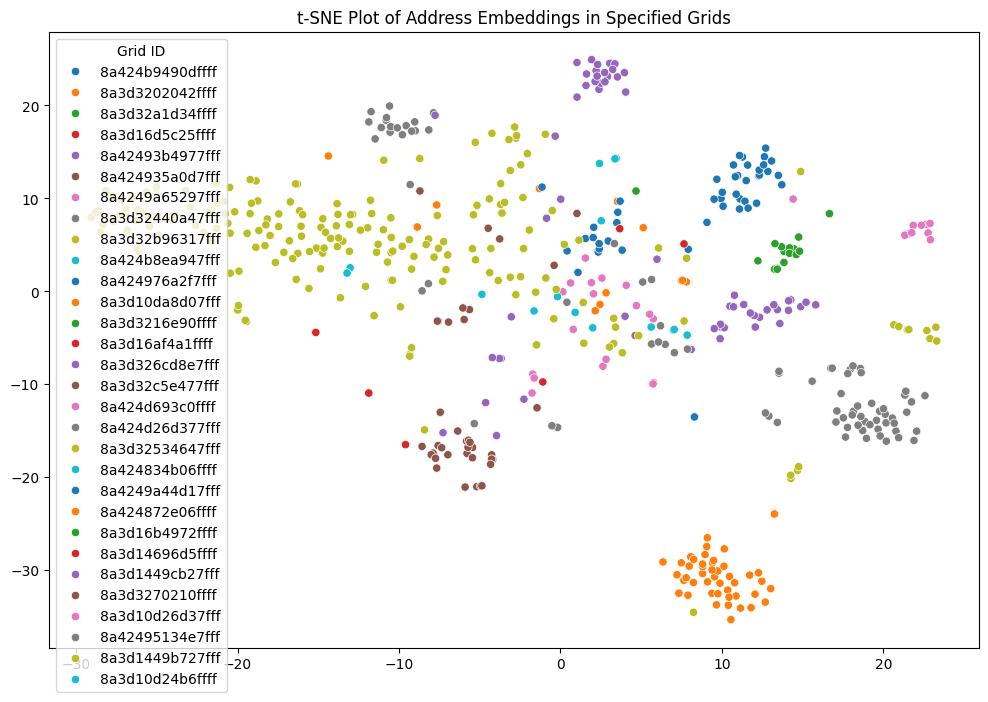

In [37]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch4'

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=30, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 , perplexity=30)

In [38]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch4'

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=30, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 , perplexity=50)

Computing embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:02<00:00, 201.58it/s]


Some weights of RobertaModel were not initialized from the model checkpoint at /home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:02<00:00, 201.73it/s]


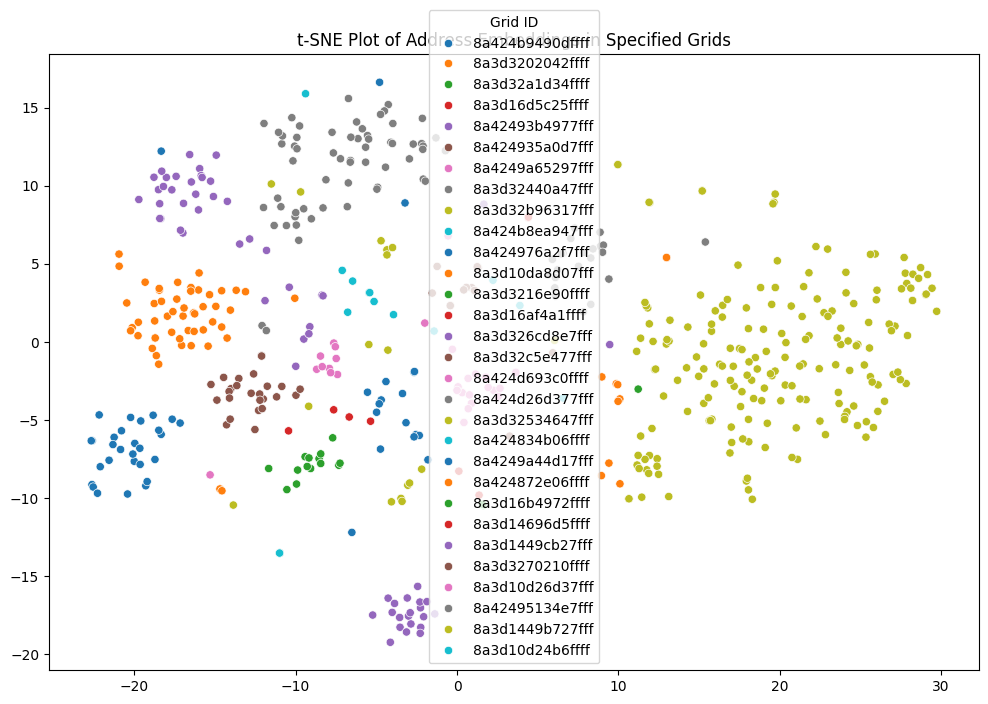

In [33]:
checkpoint_path = "/home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000"  

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=30, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 , perplexity=50)

Some weights of RobertaModel were not initialized from the model checkpoint at /home/uddeshya.singh/DataSet_triplet/Roberta_classification_r and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:03<00:00, 178.28it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


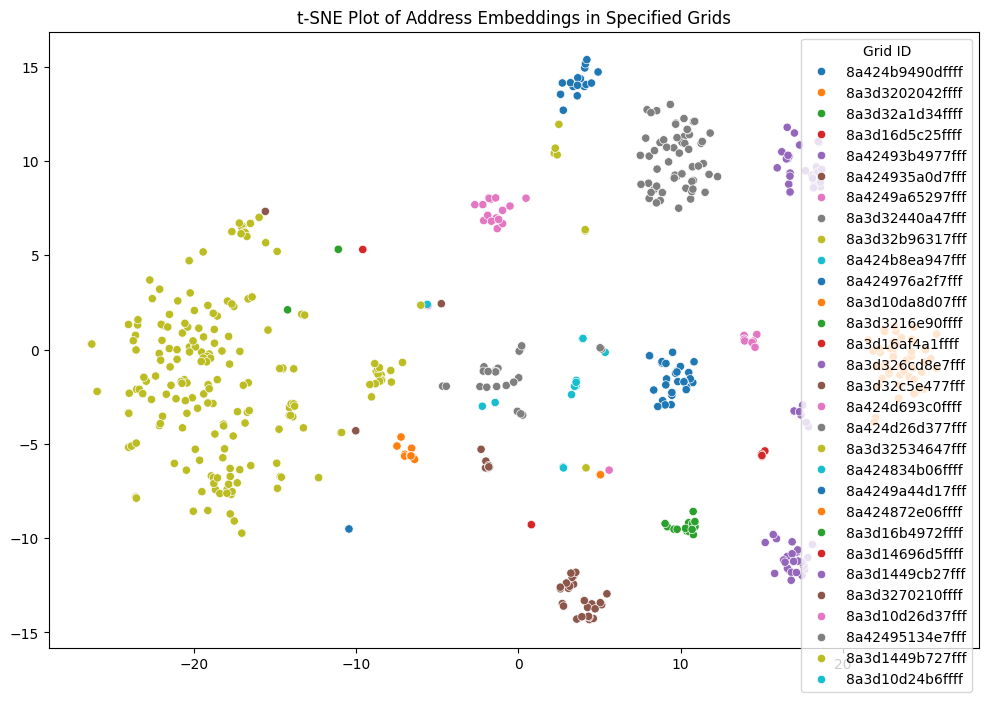

In [7]:
#### classification_model

checkpoint_path = '/home/uddeshya.singh/DataSet_triplet/Roberta_classification_r'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=30, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 ,perplexity = 50)

Some weights of RobertaModel were not initialized from the model checkpoint at /home/uddeshya.singh/DataSet_triplet/Roberta_classification_r and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 198.02it/s]


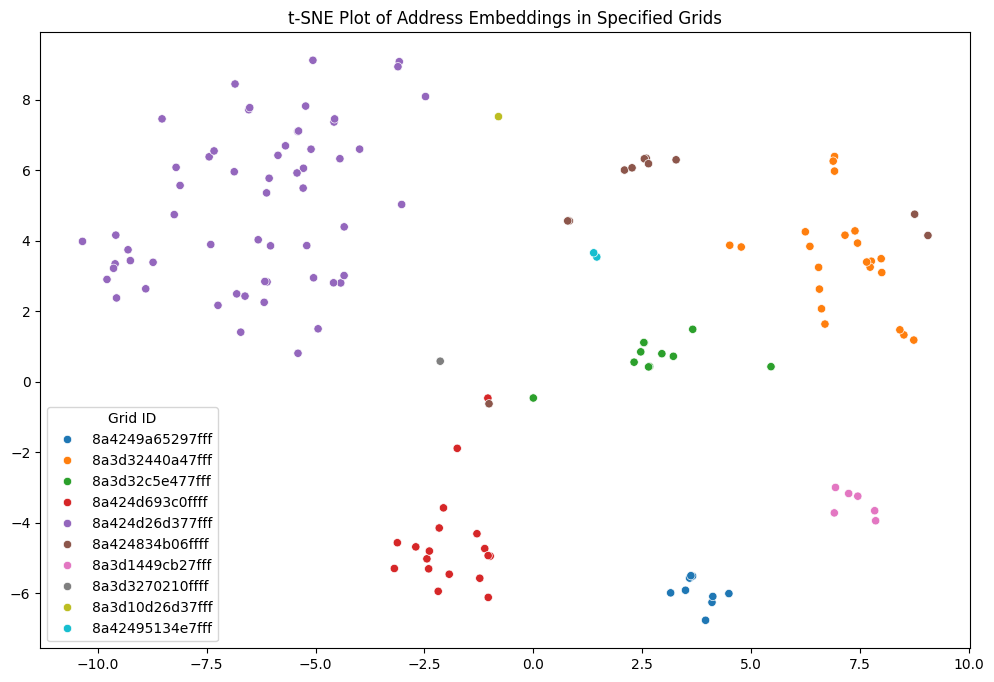

In [10]:
#### classification_model

checkpoint_path = '/home/uddeshya.singh/DataSet_triplet/Roberta_classification_r'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 ,perplexity = 30)

Computing embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:02<00:00, 203.12it/s]


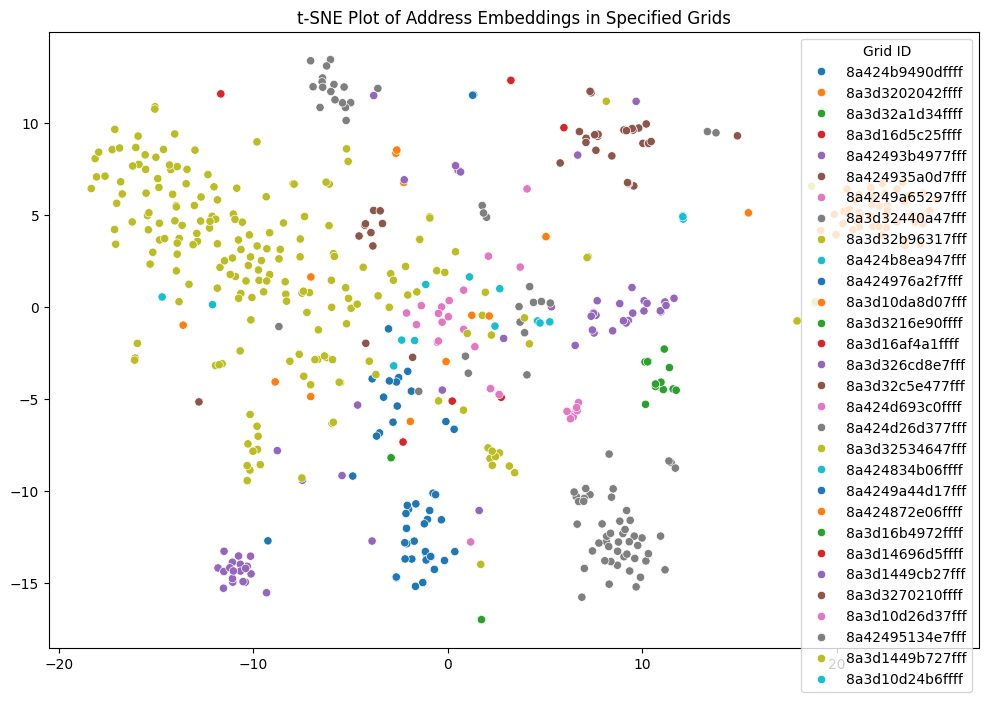

In [12]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch2'

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=30, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 , perplexity=50)

Computing embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 199.08it/s]


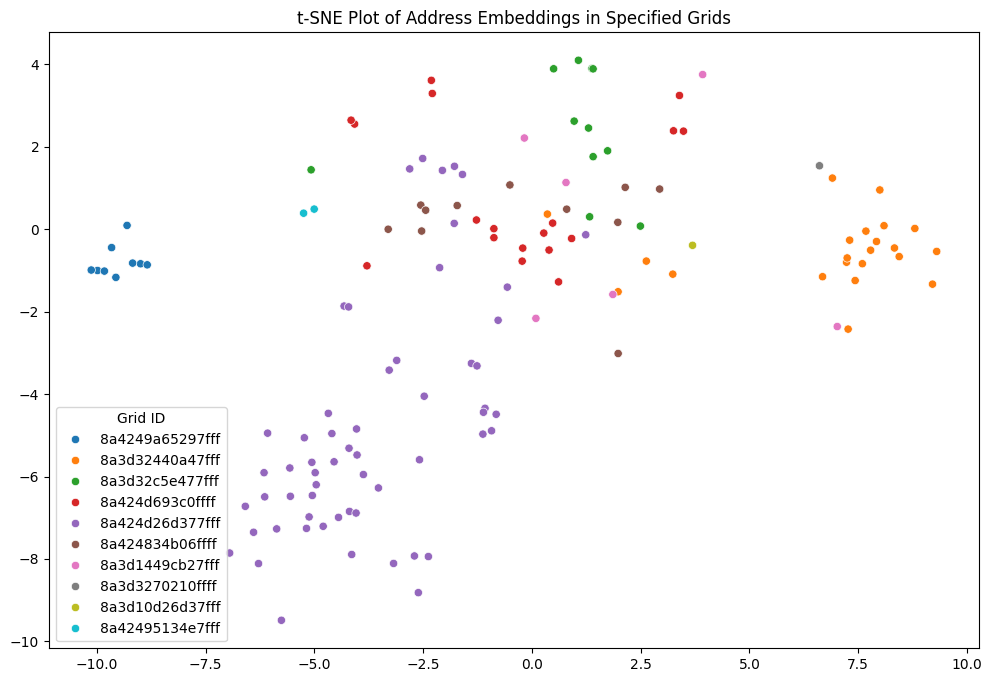

In [16]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch4'

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 ,perplexity=30)

Some weights of RobertaModel were not initialized from the model checkpoint at /home/uddeshya.singh/Experiments/Model_conversion/Model_1_R_without_city and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:05<00:00, 44.78it/s]


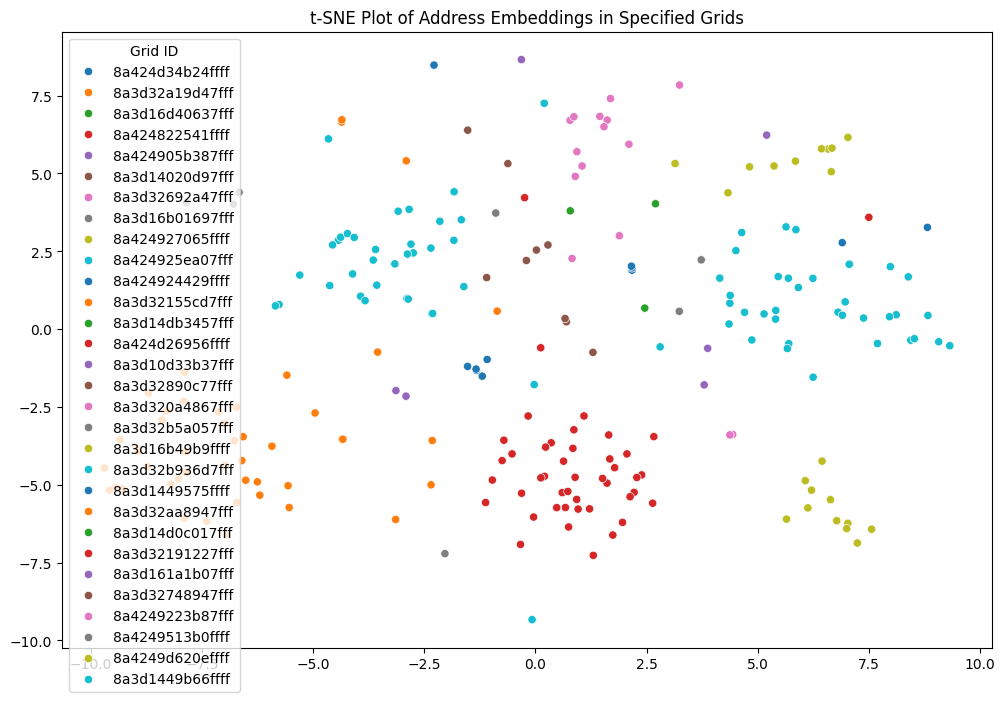

In [33]:
checkpoint_path = '/home/uddeshya.singh/Experiments/Model_conversion/Model_1_R_without_city'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=30, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 ,perplexity = 50)

In [ ]:
checkpoint_path2 = "/home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000"  

model , tokenizer , device  = load_finetuned_model(checkpoint_path2)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Some weights of RobertaModel were not initialized from the model checkpoint at /home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
### checkpoint 4

In [ ]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch4'

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 ,perplexity=5)

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 61.99it/s]


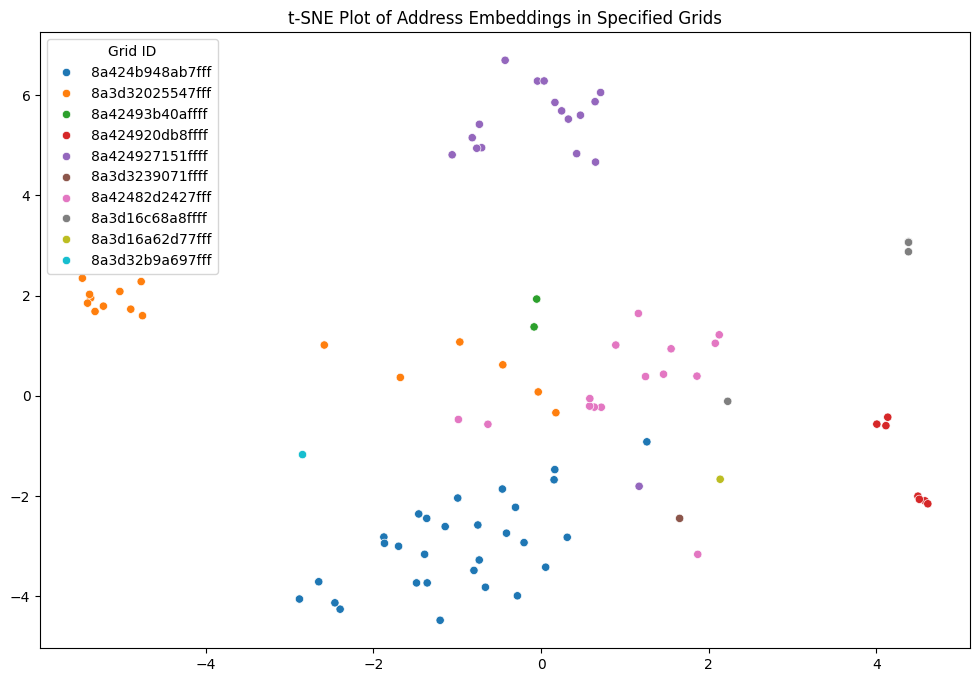

In [10]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch1'

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 63.06it/s]


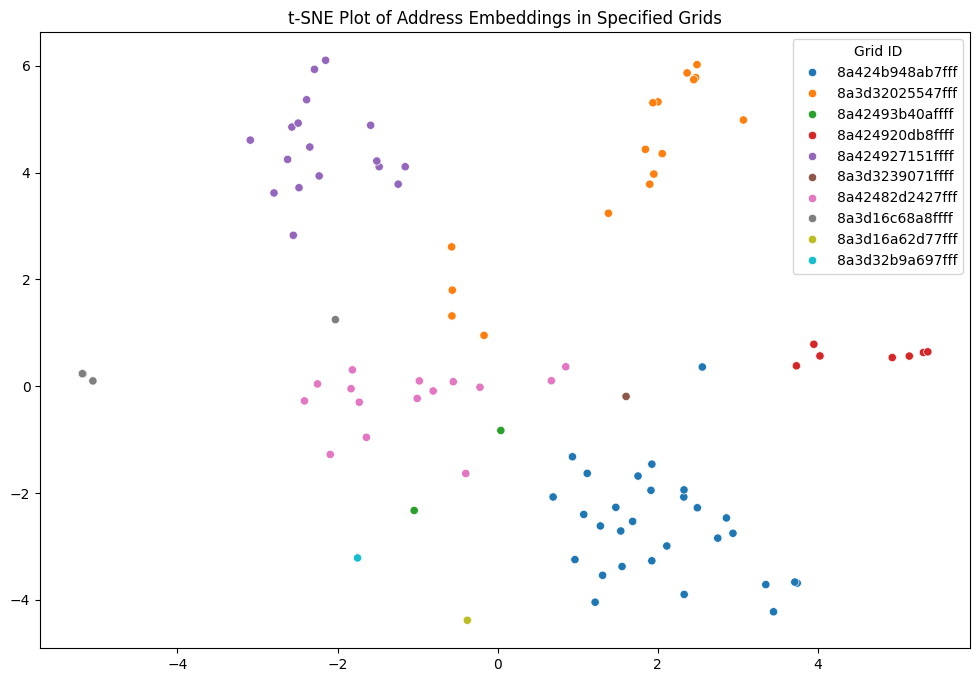

In [12]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch2'

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Some weights of RobertaModel were not initialized from the model checkpoint at /home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:02<00:00, 204.03it/s]


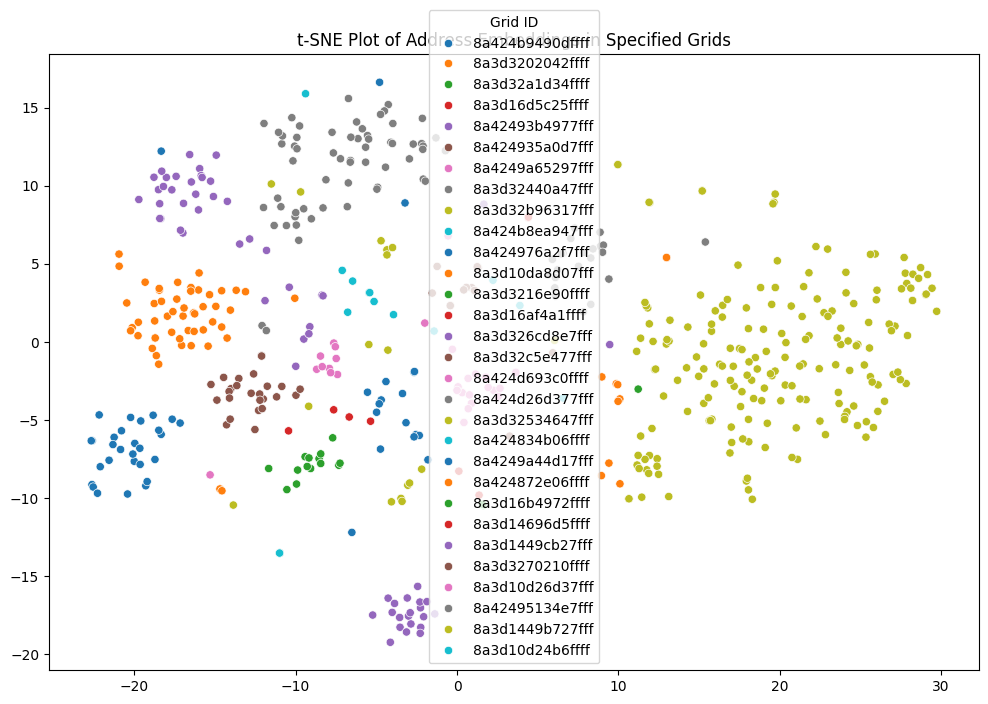

In [17]:
checkpoint_path = "/home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000"  

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=30, resolution=10, output_path='tsne_grid_plot.png' , random_n=0 , perplexity=50)

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 63.34it/s]


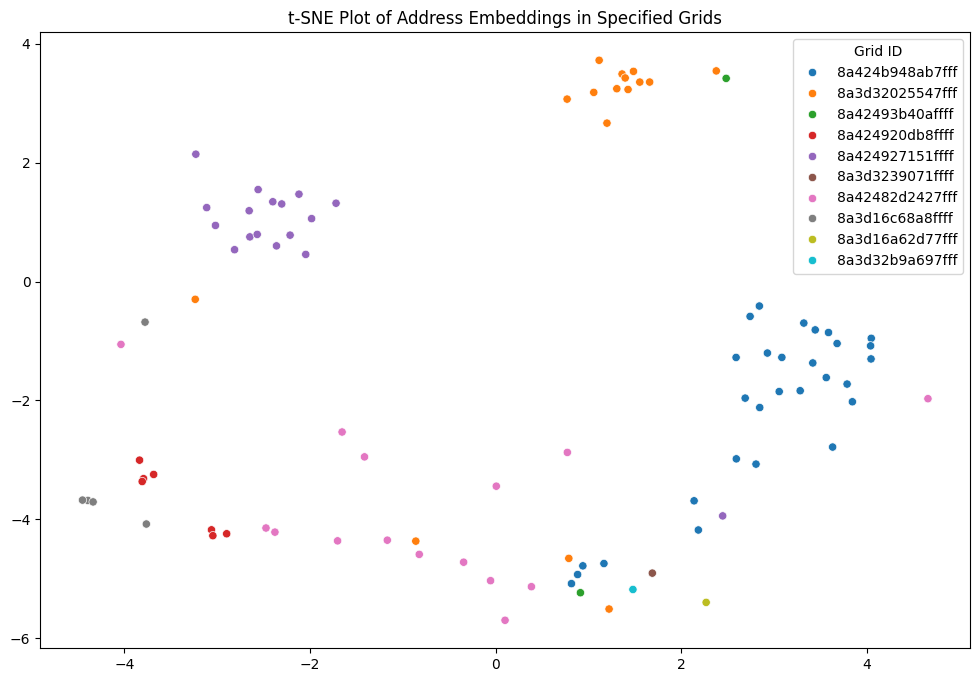

In [14]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model2.1/checkpoint_epoch_Con1'

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Some weights of RobertaModel were not initialized from the model checkpoint at /home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 110.36it/s]


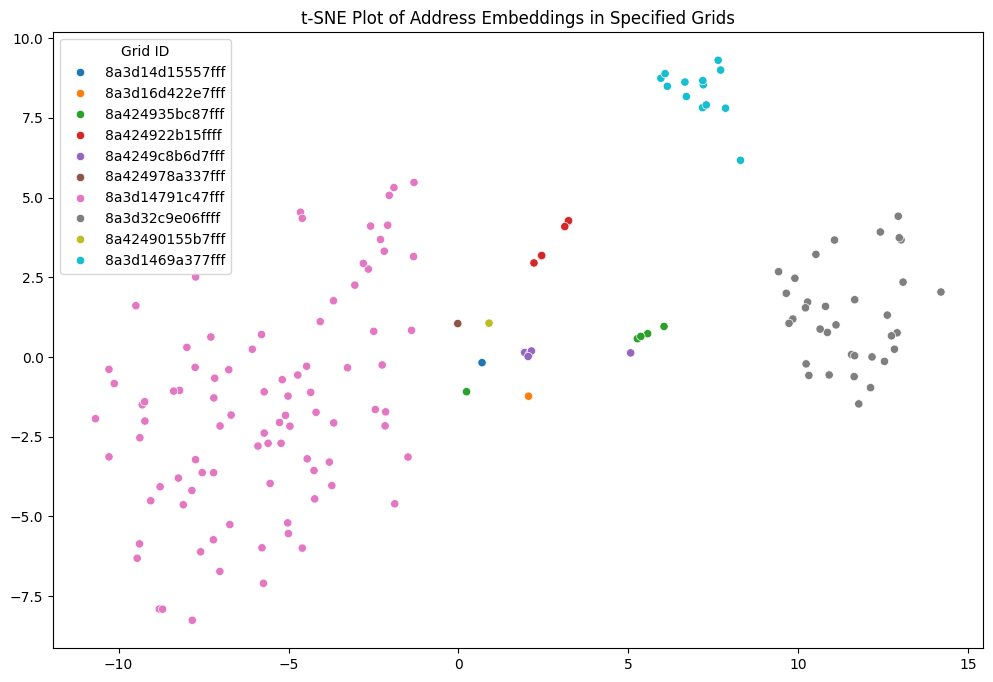

In [15]:
checkpoint_path2 = "/home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000"  

model2 , tokenizer , device  = load_finetuned_model(checkpoint_path2)
selected_grids = plot_tsne_of_grids(model2, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Computing embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 207.41it/s]


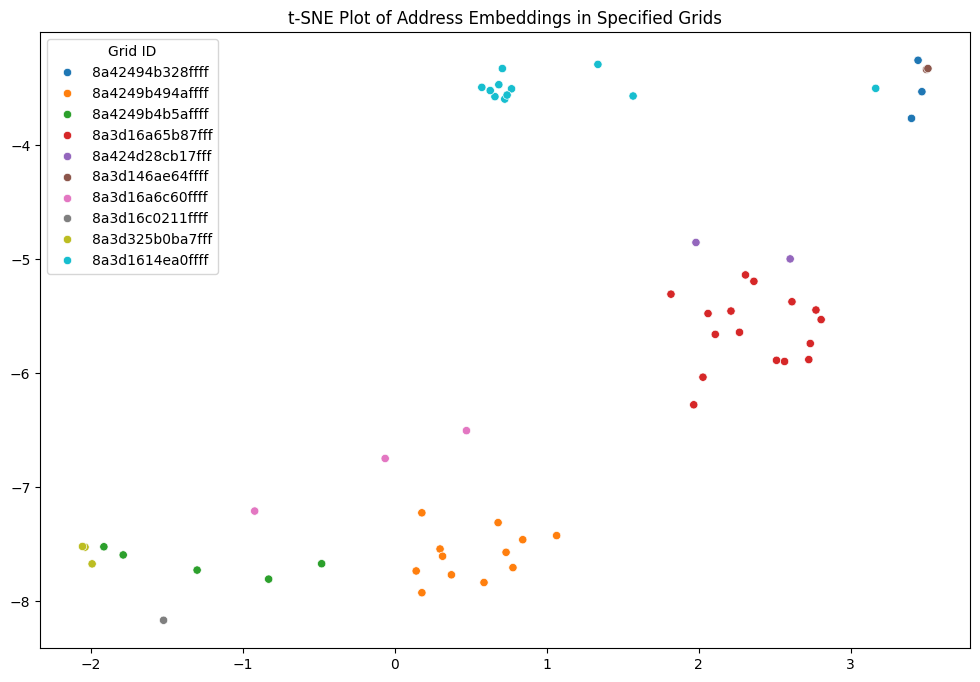

In [20]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model2.1/checkpoint_epoch_Con1'

model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

In [25]:
map_folium = plot_h3_grids_folium(lat_lngs, selected_grids, resolution=10, output_path='h3_grid_map.html')



In [41]:
checkpoint_path = '/home/uddeshya.singh/Experiments/punjab_roberta_model/checkpoint_epoch_1'  

model , tokenizer , device  = load_finetuned_model(checkpoint_path)

## Pan-India Roberta Model 

In [29]:
checkpoint_path2 = "/home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000"  

model2 , tokenizer , device  = load_finetuned_model(checkpoint_path2)

Some weights of RobertaModel were not initialized from the model checkpoint at /home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Computing embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 208.78it/s]


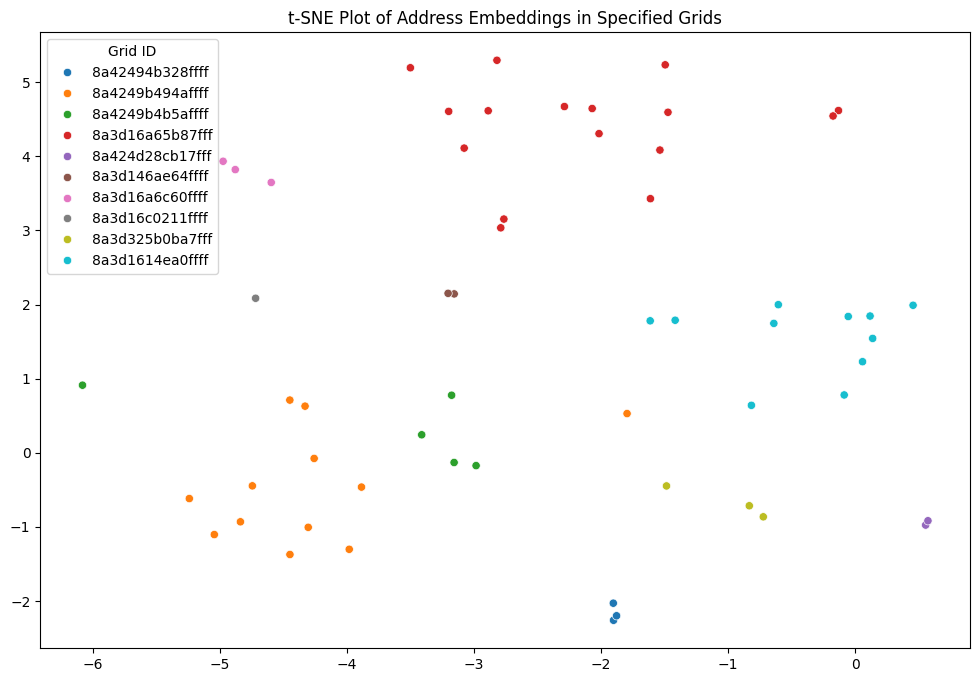

['8a4249b4b5affff',
 '8a3d146ae64ffff',
 '8a424d28cb17fff',
 '8a4249b494affff',
 '8a3d16a65b87fff',
 '8a3d1614ea0ffff',
 '8a3d16a6c60ffff',
 '8a3d16c0211ffff',
 '8a42494b328ffff',
 '8a3d325b0ba7fff']

In [30]:
plot_tsne_of_grids(model2, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

## Untrained - Roberta

In [31]:
checkpoint_path3 = '/home/devanapalli.ravi/disk_1/paper/data/untrained_models/distilroberta-base/'
model3 , tokenizer , device  = load_finetuned_model(checkpoint_path3)


Computing embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 208.54it/s]


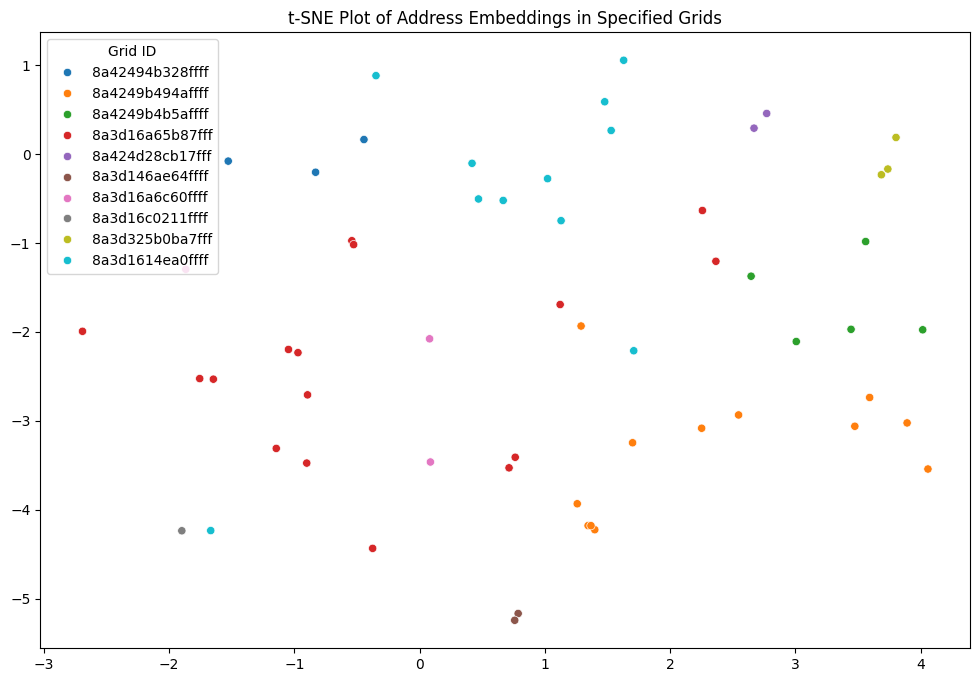

['8a4249b4b5affff',
 '8a3d146ae64ffff',
 '8a424d28cb17fff',
 '8a4249b494affff',
 '8a3d16a65b87fff',
 '8a3d1614ea0ffff',
 '8a3d16a6c60ffff',
 '8a3d16c0211ffff',
 '8a42494b328ffff',
 '8a3d325b0ba7fff']

In [32]:
plot_tsne_of_grids(model3, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 56.47it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


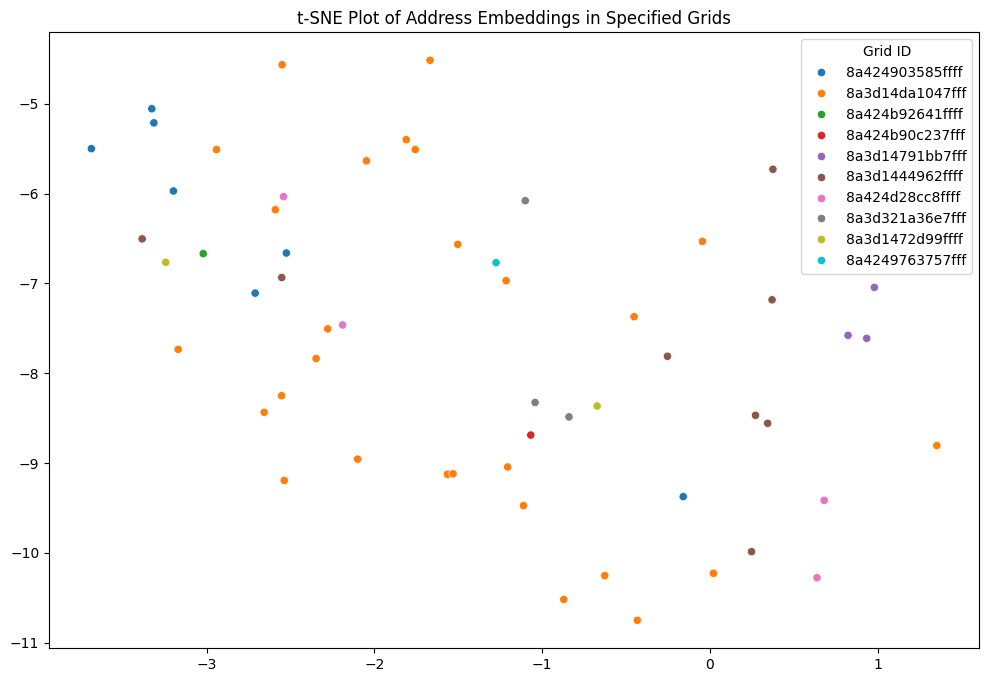

In [7]:
checkpoint_path =  '/home/devanapalli.ravi/disk_1/paper/data/untrained_models/distilroberta-base/'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Some weights of RobertaModel were not initialized from the model checkpoint at /home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 83.24it/s]


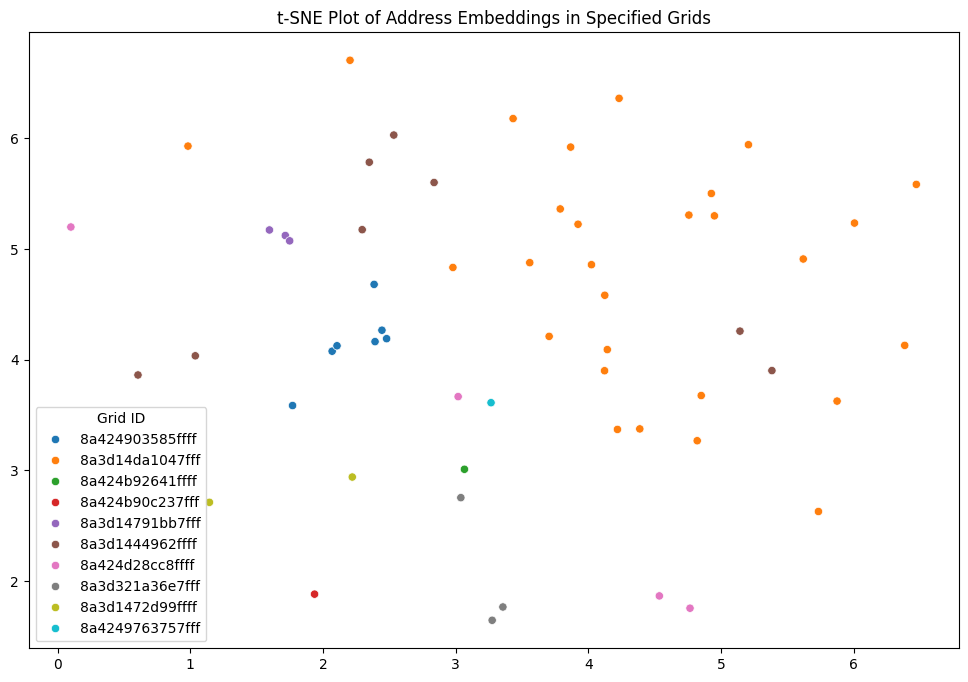

In [8]:
checkpoint_path = "/home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000"  
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 79.12it/s]


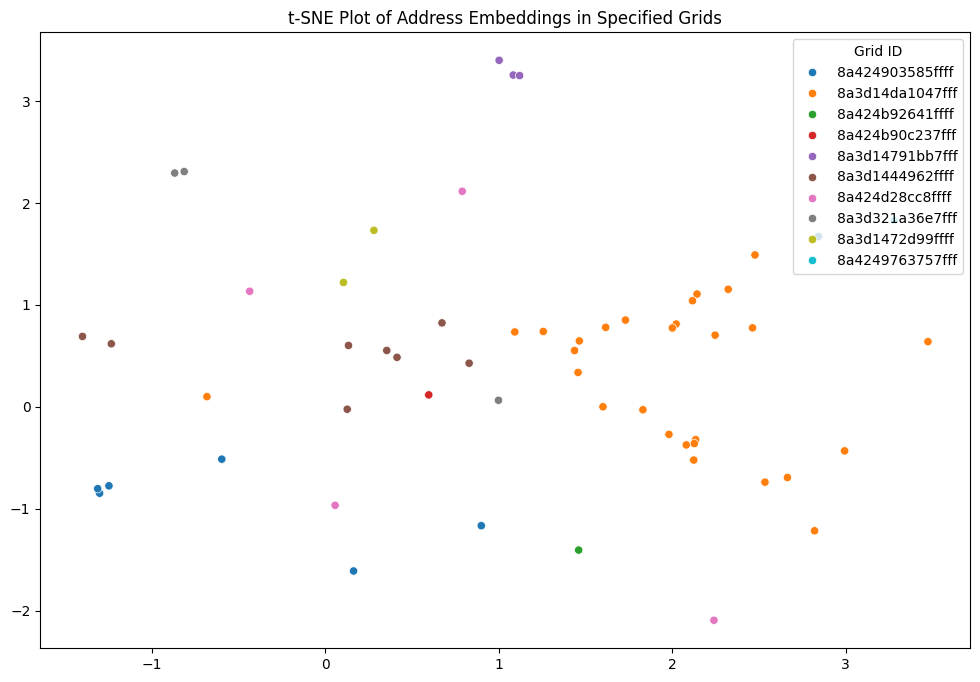

In [9]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch1'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 80.92it/s]


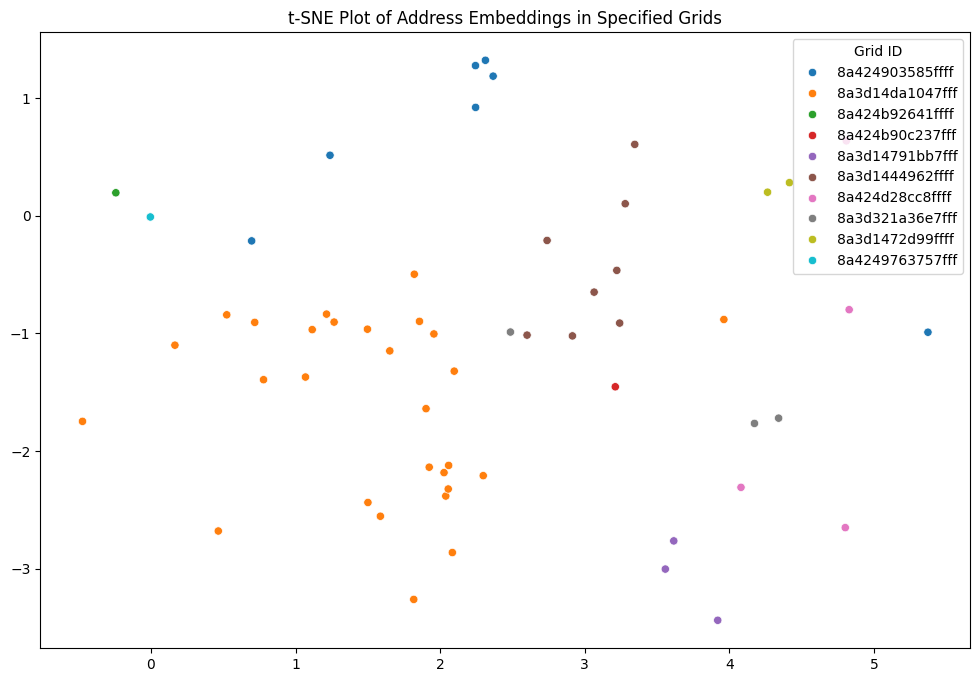

In [10]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch2'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 79.55it/s]


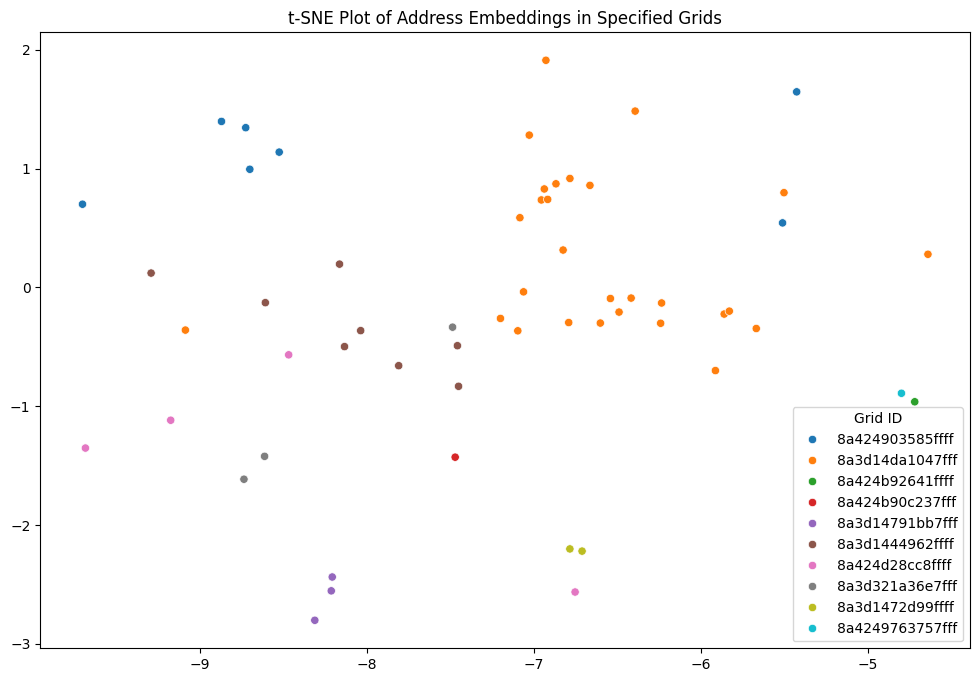

In [11]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch3'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)


Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 79.09it/s]


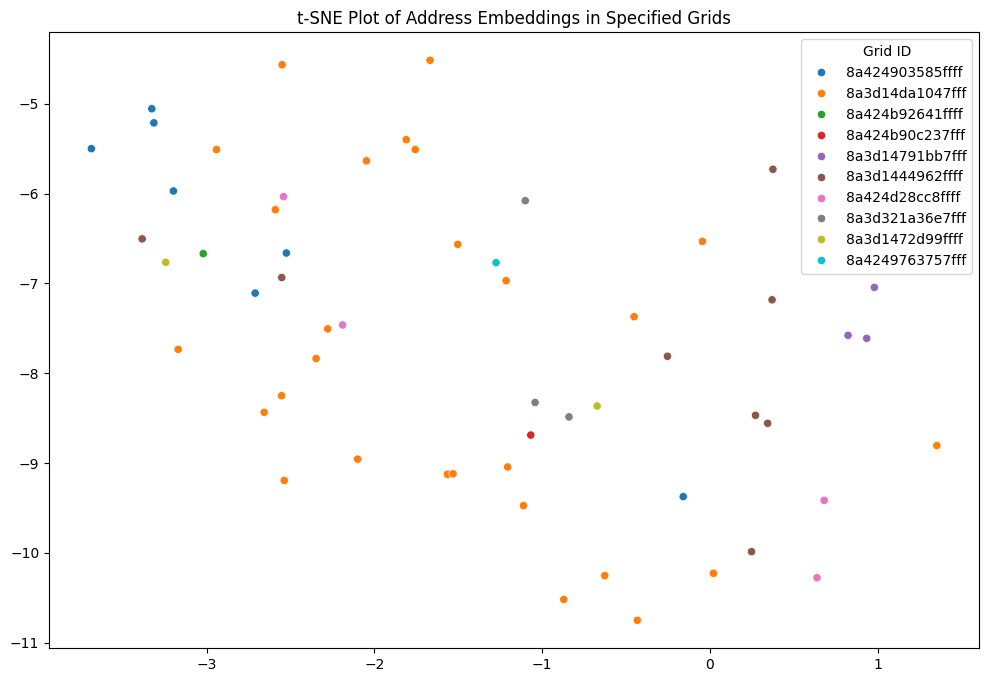

In [24]:
checkpoint_path =  '/home/devanapalli.ravi/disk_1/paper/data/untrained_models/distilroberta-base/'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

Some weights of RobertaModel were not initialized from the model checkpoint at /home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 79.22it/s]


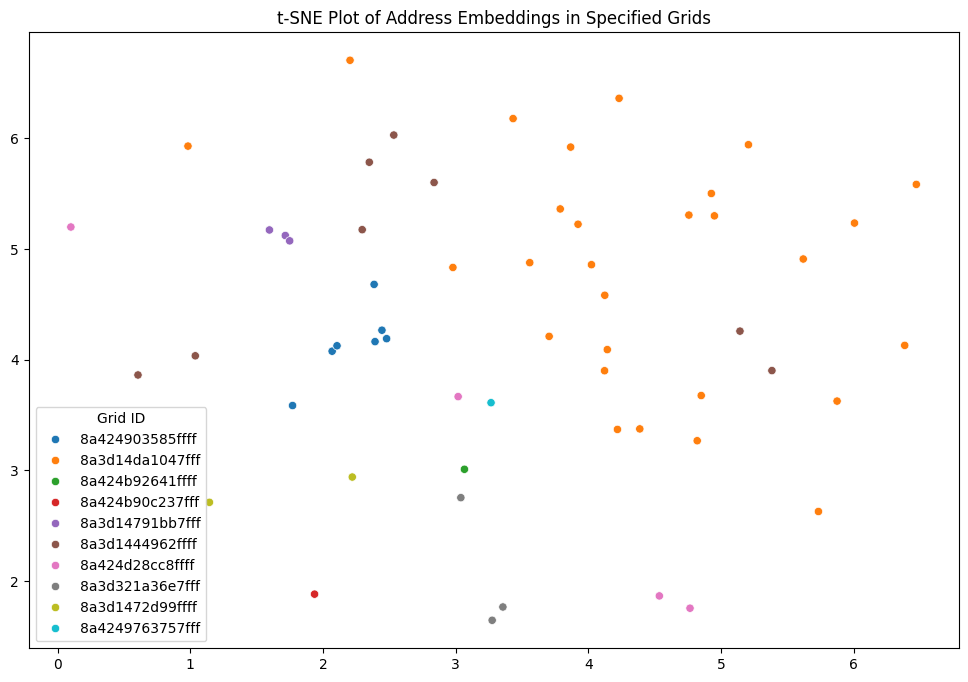

In [25]:
checkpoint_path = "/home/devanapalli.ravi/disk_1/paper/data/gpu_re_trained_models/lm_retrained_models/pan_india_train_threshold/pan_india_train_threshold_out_dir_5_epochs/checkpoint-375000"  
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)


Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 79.24it/s]


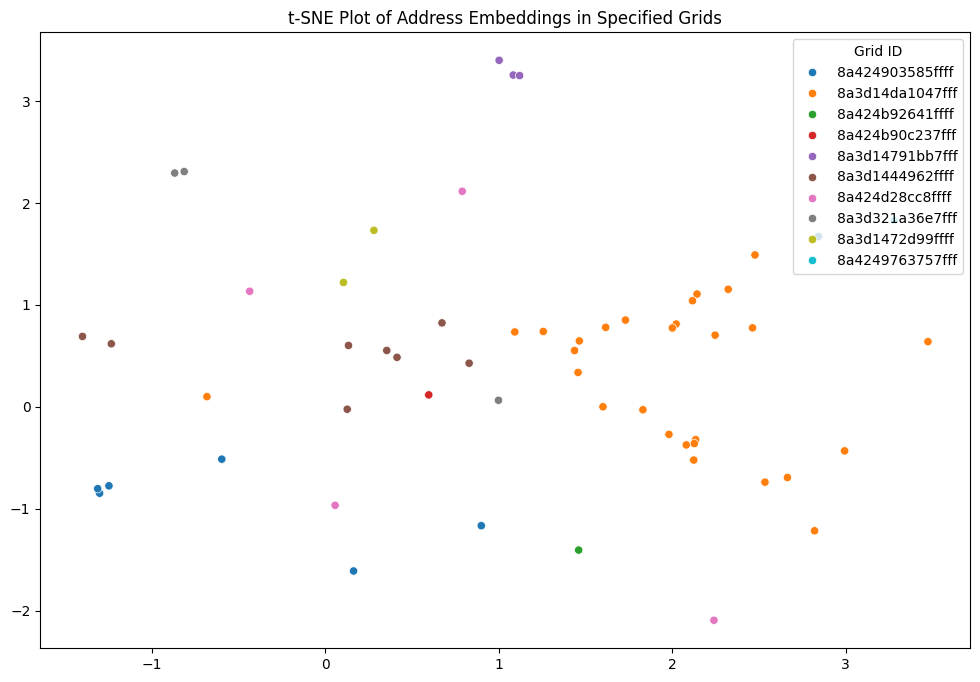

In [26]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch1'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)


Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 83.33it/s]


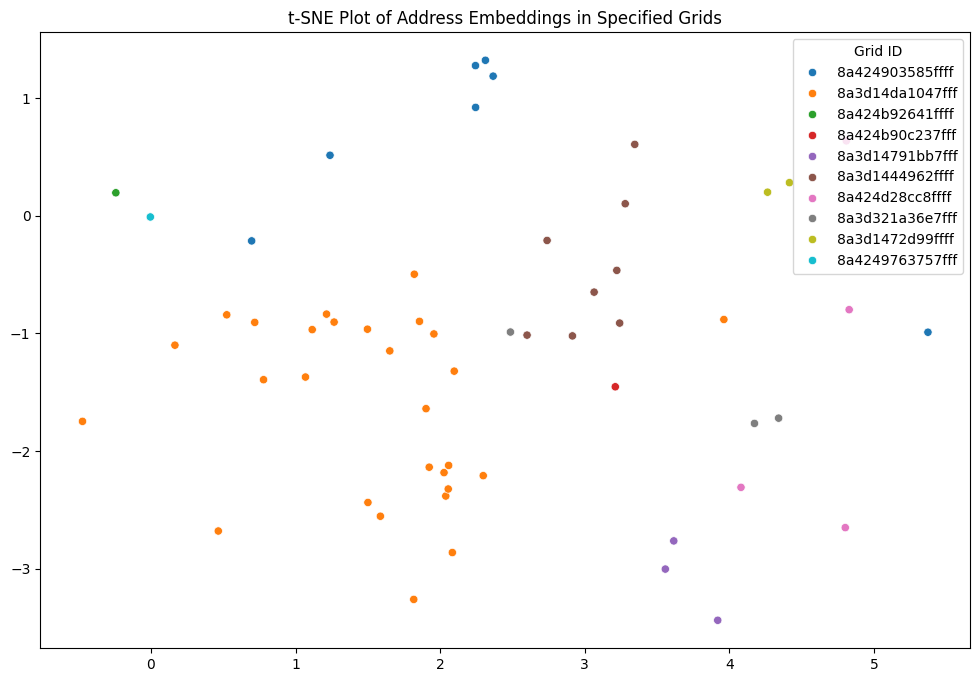

In [27]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch2'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)


Computing embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 70.87it/s]


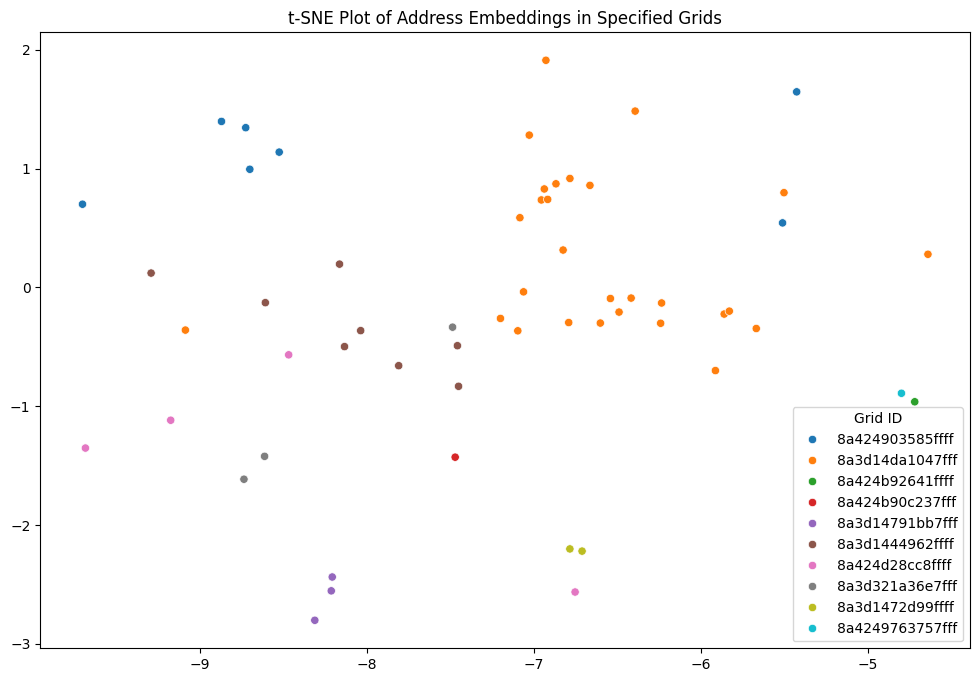

In [28]:
checkpoint_path =  '/home/uddeshya.singh/Experiments/punjab_roberta_model_without_city_05/checkpoint_epoch3'
model , tokenizer , device  = load_finetuned_model(checkpoint_path)
selected_grids = plot_tsne_of_grids(model, addresses, lat_lngs, grid_ids=None, num_grids=10, resolution=10, output_path='tsne_grid_plot.png' , random_n=0)

In [14]:
def get_embedding(model, text):
    inputs = tokenizer(text, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

In [18]:
embeddings = np.vstack([get_embedding(model,addr) for addr in tqdm(addresses[:1000], desc="Computing embeddings")]) 


Computing embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.41it/s]


In [19]:
len(embeddings)

1000

In [20]:
dim = embeddings.shape[1]
annoy_index = AnnoyIndex(dim, 'euclidean')
for i, embedding in enumerate(embeddings):
    annoy_index.add_item(i, embedding)

annoy_index.build(10)

True

Computing embeddings:   0%|▌                                                                                                                                                                                | 955/282737 [00:20<22:19, 210.40it/s]

In [8]:
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import h3
from tqdm import tqdm
import folium

def get_embedding(model, text, tokenizer, device):
    inputs = tokenizer(text, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

def get_embeddings(model, texts, tokenizer, device):
    embeddings = [get_embedding(model, text, tokenizer, device) for text in tqdm(texts, desc="Computing embeddings")]
    return np.vstack(embeddings)

def plot_tsne_of_neighbouring_grids(model, tokenizer, device, addresses, lat_lngs, resolution=10, output_path='tsne_neighbouring_grids.png', perplexity=10):
    # Generate H3 indices for the provided latitudes and longitudes
    h3_indices = [h3.geo_to_h3(lat, lng, resolution) for lat, lng in lat_lngs]

    # Select a random center grid
    unique_grids = list(set(h3_indices))
    center_grid = np.random.choice(unique_grids)
    
    # Find the neighbors of the center grid
    first_order_neighbours = h3.k_ring(center_grid, 1)
    second_order_neighbours = h3.k_ring(center_grid, 2)
    third_order_neighbours = h3.k_ring(center_grid, 3)
    
    # Combine all neighbors including the center grid
    selected_grids = set(first_order_neighbours + second_order_neighbours + third_order_neighbours)
    
    # Filter addresses that fall within the selected grids
    selected_addresses = [addresses[i] for i in range(len(addresses)) if h3_indices[i] in selected_grids]
    selected_h3_indices = [h3_indices[i] for i in range(len(h3_indices)) if h3_indices[i] in selected_grids]
    
    # Get embeddings for the selected addresses
    embeddings = get_embeddings(model, selected_addresses, tokenizer, device)
    
    # Apply t-SNE on the embeddings
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Plot the t-SNE embeddings
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=selected_h3_indices, palette="tab10")
    plt.title('t-SNE Plot of Address Embeddings in Neighbouring Grids')
    plt.legend(title='Grid ID')
    plt.savefig(output_path)
    plt.show()
    
    return list(selected_grids)

def plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='h3_neighbouring_grids_plot.png'):
    plt.figure(figsize=(12, 8))
    for grid in selected_grids:
        boundary = h3.h3_to_geo_boundary(grid)
        boundary = list(boundary) + [boundary[0]]  
        boundary = np.array(boundary)
        plt.plot(boundary[:, 1], boundary[:, 0], 'k-')  
        plt.fill(boundary[:, 1], boundary[:, 0], alpha=0.4)

    plt.title('H3 Neighbouring Grid Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(output_path)
    plt.show()

def plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='h3_neighbouring_grids_map.html'):
    center_lat = np.mean([lat for lat, lng in lat_lngs])
    center_lng = np.mean([lng for lat, lng in lat_lngs])
    map_folium = folium.Map(location=[center_lat, center_lng], zoom_start=12)

    for grid in selected_grids:
        boundary = h3.h3_to_geo_boundary(grid)
        boundary = [(lat, lng) for lat, lng in boundary]  
        boundary.append(boundary[0])  
        
        folium.Polygon(locations=boundary, color='blue', fill=True, fill_opacity=0.4).add_to(map_folium)

    map_folium.save(output_path)

    return map_folium

def load_finetuned_model(checkpoint_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModel.from_pretrained(checkpoint_path)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    model = model.to(device)
    return model, tokenizer, device

# Example usage:
input_pickle_path = 'DataSet_triplet/PUNJAB_05_without_city.pkl'

with open(input_pickle_path, 'rb') as f:
    data = pickle.load(f)

triplets = data.get('triplets', [])
addresses = data.get('addresses', [])
lat_lngs = data.get('lat_lngs', [])

checkpoint_path = 'path_to_your_finetuned_model'
model, tokenizer, device = load_finetuned_model(checkpoint_path)

selected_grids = plot_tsne_of_neighbouring_grids(model, tokenizer, device, addresses, lat_lngs, resolution=10, output_path='tsne_neighbouring_grids.png', perplexity=10)
plot_h3_grids_neighbours(lat_lngs, selected_grids, resolution=10, output_path='h3_neighbouring_grids_plot.png')
plot_h3_grids_folium_neighbours(lat_lngs, selected_grids, resolution=10, output_path='h3_neighbouring_grids_map.html')


/home/uddeshya.singh/miniconda3/envs/uddeshya_env/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like path_to_your_finetuned_model is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [135]:
def normalize_scores(scores):
    max_score = max(scores)
    return [score / max_score for score in scores]

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6371000
    return R * c

def get_embedding(model, text):
    inputs = tokenizer(text, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

def remove_outliers(coords):
    latitudes, longitudes = zip(*coords)
    lat_mean, lon_mean = np.mean(latitudes), np.mean(longitudes)
    lat_std, lon_std = np.std(latitudes), np.std(longitudes)
    
    filtered_coords = [(lat, lon) for lat, lon in coords if (lat_mean - 2*lat_std <= lat <= lat_mean + 2*lat_std) and (lon_mean - 2*lon_std <= lon <= lon_mean + 2*lon_std)]
    return filtered_coords

# def compute_convex_hull(coords):
#     if len(coords) < 3:
#         return coords
#     hull = ConvexHull(coords)
#     hull_coords = [coords[vertex] for vertex in hull.vertices]
#     return hull_coords

def retrieve_neighbours(query, query_coords, top_n=10, bandwidth=200):
    query_embedding = get_embedding(base_model, query).reshape(1, -1)
    indices, distances = annoy_index.get_nns_by_vector(query_embedding.flatten(), top_n, include_distances=True)
    
    
    # # Normalize distances with the highest distance
    # normalized_distances = normalize_scores(distances)
    # print(normalized_distances )
    
    # # Convert normalized distances to similarity scores
    # similarity_scores = [1 - dist for dist in normalized_distances]
    
    
    # threshold = 0.0000001
    # pruned_indices = [i for i, score in zip(indices, similarity_scores) if score >= threshold]
    # retrieved_addresses = [addresses[i] for i in pruned_indices]
    # retrieved_coords = [lat_lngs[i] for i in pruned_indices]
    # pruned_scores = [score for score in similarity_scores if score >= threshold]
    
    normalized_scores = normalize_scores([1 - dist for dist in distances])
    threshold = 0.25
    pruned_indices = [i for i, score in zip(indices, normalized_scores) if score >= threshold]
    retrieved_addresses = [addresses[i] for i in pruned_indices]
    retrieved_coords = [lat_lngs[i] for i in pruned_indices]
    pruned_scores = [score for score in normalized_scores if score >= threshold]

    filtered_coords = remove_outliers(retrieved_coords)

    hull_coords = compute_convex_hull(filtered_coords)
    
    haversine_distances = np.array([haversine(query_coords[0], query_coords[1], coord[0], coord[1]) for coord in hull_coords])

    kde = gaussian_kde(haversine_distances, bw_method=bandwidth / 1000)
    kde_scores = kde(haversine_distances)

    max_kde_score = max(kde_scores)
    normalized_kde_scores = [score / max_kde_score for score in kde_scores]

    return list(zip(retrieved_addresses, filtered_coords, pruned_scores, normalized_kde_scores))



In [136]:
query_address = "164 f ghal kalan moga Moga"
query_coords =[30.8128771, 75.10901820000002]

neighbors = retrieve_neighbours(query_address, query_coords)
for neighbor in neighbors:
    print(f"Address: {neighbor[0]}, Coordinates: {neighbor[1]}, Score: {neighbor[2]}, KDE Score: {neighbor[3]}")
    

Address: samana warichan patti near kariyana shop warichan patti Samana, Coordinates: (30.16867490000001, 76.2012402), Score: 1.0, KDE Score: 0.6465541849341422
Address: sukhjinder singh deputy so sawinder singh vill bijliwal po sarwali teh batala dist gurdaspur dera baba nanak road Batala, Coordinates: (31.8785977, 75.14448809999998), Score: 1.0099561060013464, KDE Score: 0.519223217285559
Address: s 419 holy heart school jarg holy heart school jarg Ludhiana District, Coordinates: (30.610936699999996, 76.0691467), Score: 1.0159419814674147, KDE Score: 0.9997965488227001
Address: vill darshopur po rattangarh disit pathankot taragarh Pathankot District, Coordinates: (32.21068880000001, 75.4607909), Score: 1.0189276058245493, KDE Score: 0.6468585241147569
Address:  27 b street no 13 dabur colony satjot nagar dhandra road lal kothi wali gali ludhiana lal kothi Ludhiana, Coordinates: (30.854565500000003, 75.8328475), Score: 1.0214340813526193, KDE Score: 1.0


In [137]:
addresses[10] , lat_lngs[10]

(' 164 f ghal kalan moga Moga', [30.8128771, 75.10901820000002])

In [138]:
import folium
import h3

def add_hexagons_to_map(h3_cells, color, m):
    """
    Adds H3 hexagons to a Folium map.
    
    :param h3_cells: List of H3 cell IDs.
    :param color: Color of the hexagons.
    :param m: Folium map object.
    """
    for cell in h3_cells:
        boundary = h3.h3_to_geo_boundary(cell)
        boundary = [(lat, lng) for lat, lng in boundary]
        folium.Polygon(locations=boundary, color=color, fill=True, fill_opacity=0.2).add_to(m)

def visualize_query_and_neighbors(query_coords, neighbors, resolution=9):
    """
    Visualizes the query and its neighbors on a Folium map with H3 hexagons.
    
    :param query_coords: Coordinates of the query point.
    :param neighbors: List of neighbors with address, coordinates, score, and KDE score.
    :param resolution: H3 resolution for hexagons.
    """
    m = folium.Map(location=query_coords, zoom_start=12)

    folium.Marker(location=query_coords, popup='Query', icon=folium.Icon(color='blue')).add_to(m)
    query_cell = h3.geo_to_h3(query_coords[0], query_coords[1], resolution)
    add_hexagons_to_map([query_cell], 'blue', m)

    for neighbor in neighbors:
        address, coords, score, kde_score = neighbor
        folium.Marker(location=coords, popup=f'{address}\nScore: {score:.2f}\nKDE Score: {kde_score:.2f}', icon=folium.Icon(color='green')).add_to(m)
        neighbor_cell = h3.geo_to_h3(coords[0], coords[1], resolution)
        add_hexagons_to_map([neighbor_cell], 'green', m)

    m.save('query_neighbors_map.html')
    print("visualisation saved !")


In [139]:
query_address = "164 f ghal kalan moga Moga"
query_coords =[30.8128771, 75.10901820000002]

neighbors = retrieve_neighbours(query_address, query_coords)
visualize_query_and_neighbors(query_coords, neighbors)

visualisation saved !
